In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_car_plate_detection_path = kagglehub.dataset_download('andrewmvd/car-plate-detection')
smaildurcan_turkish_license_plate_dataset_path = kagglehub.dataset_download('smaildurcan/turkish-license-plate-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'car-plate-detection' dataset.
Using Colab cache for faster access to the 'turkish-license-plate-dataset' dataset.
Data source import complete.


In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00


In [ ]:
!pip install -q pytesseract
!pip install -q easyocr
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from xml.dom import minidom
import random
import easyocr
from ultralytics import YOLO
import yaml
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import pytesseract
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 15.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# -*- coding: utf-8 -*-

lut={}
lut["accessory"] =0
lut["top"]       =1
lut["bottom"]    =2
lut["bag"]       =3
lut["shoes"]     =4



def convert_coordinates(size, box):
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


def convert_xml2yolo( lut,input_path, output_path ):

    if not os.path.exists(output_path):
         os.makedirs(output_path, exist_ok=True)

    for fname in glob(f"{input_path}/*.xml"):

        xmldoc = minidom.parse(fname)
        annot_fname = fname.split("/")[-1][:-4]
        fname_out = f"{output_path}/{annot_fname}.txt"

        with open(fname_out, "w") as f:

            itemlist = xmldoc.getElementsByTagName('object')
            size = xmldoc.getElementsByTagName('size')[0]
            width = int((size.getElementsByTagName('width')[0]).firstChild.data)
            height = int((size.getElementsByTagName('height')[0]).firstChild.data)

            for item in itemlist:
                # get class label
                classid =  (item.getElementsByTagName('name')[0]).firstChild.data
                if classid in lut:
                    label_str = str(lut[classid])
                else:
                    label_str = "0"
                    #print ("warning: label '%s' not in look-up table" % classid)

                # get bbox coordinates
                xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
                ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
                xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
                ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
                b = (float(xmin), float(xmax), float(ymin), float(ymax))
                bb = convert_coordinates((width,height), b)
                #print(bb)

                f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')

        #print ("wrote %s" % fname_out)
    print("Converting is finished!")

convert_xml2yolo( lut, input_path = "/kaggle/input/car-plate-detection/annotations", output_path = "/kaggle/working/annotations")

Converting is finished!


In [ ]:
def create_directories_if_not_exist(directories: list):
    # Assert: Is the parameter a list?
    assert isinstance(directories, list), "The parameter must be a list (array)."

    # Assert: Is every element in the list a string?
    for dir_path in directories:
        assert isinstance(dir_path, str), f"The element '{dir_path}' in the list is not a string."

    # Create directories
    for dir_path in directories:
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
            print(f"Created: {dir_path}")
        else:
            print(f"Already exists: {dir_path}")

In [ ]:
directories = [
    "/kaggle/working/car_plate_dataset",
    "/kaggle/working/car_plate_dataset/images",
    "/kaggle/working/car_plate_dataset/labels",
    "/kaggle/working/car_plate_dataset/images/train",
    "/kaggle/working/car_plate_dataset/images/val",
    "/kaggle/working/car_plate_dataset/labels/train",
    "/kaggle/working/car_plate_dataset/labels/val"
]

create_directories_if_not_exist(directories)

Created: /kaggle/working/car_plate_dataset
Created: /kaggle/working/car_plate_dataset/images
Created: /kaggle/working/car_plate_dataset/labels
Created: /kaggle/working/car_plate_dataset/images/train
Created: /kaggle/working/car_plate_dataset/images/val
Created: /kaggle/working/car_plate_dataset/labels/train
Created: /kaggle/working/car_plate_dataset/labels/val


In [ ]:
def split_images_and_labels(val_size = 0.1, input_dir = "/kaggle/input/car-plate-detection",
                           output_dir = "/kaggle/working/car_plate_dataset"):

        img_path = os.listdir(f"{input_dir}/images")
        label_path = os.listdir(f"{input_dir}/annotations")
        imgs_length = len(img_path)
        for i,img in enumerate(img_path):
            spname = "train" if i < int(imgs_length*float(1 - val_size)) else "val"

            #print(spname)

            os.system(f"cp {input_dir}/images/{img} {output_dir}/images/{spname}/{img}")
            #print(f"the image {input_dir}/images/{img} image copied to {output_dir}/images/{spname}/{img}")

            os.system(f"cp /kaggle/working/annotations/{img.split('.')[0]}.txt {output_dir}/labels/{spname}/{img.split('.')[0]}.txt")
            #print(f"the label /kaggle/working/annotations/{img.split('.')[0]}.txt image copied to {output_dir}/labels/{spname}/{img.split('.')[0]}.txt")

        print("Splitting is finished!")

split_images_and_labels()

Splitting is finished!


In [ ]:
# Data to be written to the YAML file
data = {
    'train': '/kaggle/working/car_plate_dataset/images/train',
    'val': '/kaggle/working/car_plate_dataset/images/val',
    'names': {
        0: "number_plate"
    } # List formatında olmalı!
}

# Writing the data to a YAML file
with open('data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("Data has been written to 'data.yaml'")

Data has been written to 'data.yaml'


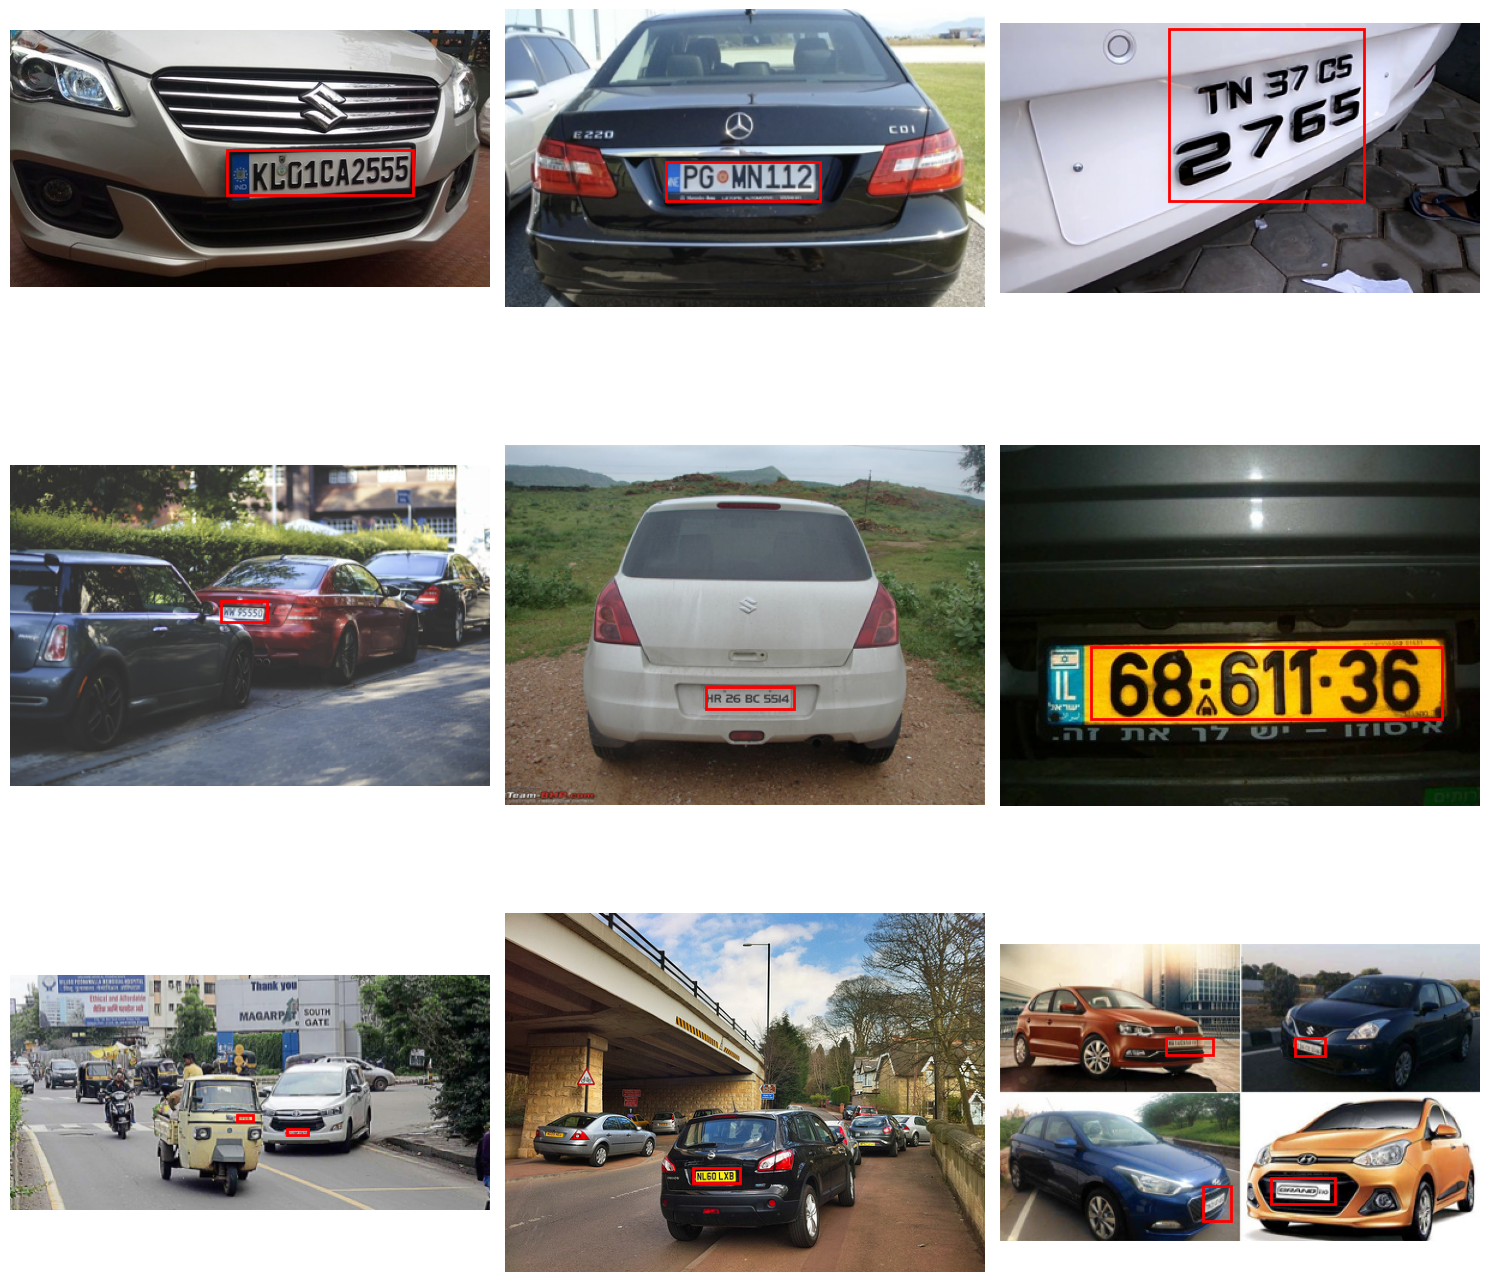

In [ ]:
# File paths
image_dir = "/kaggle/working/car_plate_dataset/images/train"
label_dir = "/kaggle/working/car_plate_dataset/labels/train"

# Supported extensions
image_extensions = ["*.jpg", "*.jpeg", "*.png"]

# Collect all image files
image_paths = []
for ext in image_extensions:
    image_paths.extend(glob(os.path.join(image_dir, ext)))

# Use the first 9 images
image_paths = sorted(image_paths)[:9]

# Draw a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Find the corresponding label file (change extension to .txt)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(label_dir, base_name + ".txt")

    # Draw with Matplotlib
    ax = axes[idx]
    ax.imshow(img)
    ax.axis("off")

    # Draw boxes if labels exist
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())

            # Convert from YOLO format to pixels
            x1 = int((x_center - box_width / 2) * w)
            y1 = int((y_center - box_height / 2) * h)
            x2 = int((x_center + box_width / 2) * w)
            y2 = int((y_center + box_height / 2) * h)

            # Draw rectangle
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [ ]:
# Check the number of GPUs
gpu_count = torch.cuda.device_count()
device = list(range(gpu_count)) if gpu_count > 1 else 0

model = YOLO("yolo11n.pt")

results = model.train(
    data="/content/data.yaml",   # Dataset configuration
    epochs=200,                         # 200 epochs
    imgsz=640,                          # Suitable for smaller images
    batch=32,                            # Adjustable based on GPU RAM
    workers=2,                          # Ideal starting value for Tesla T4
    device=device,                      # GPU setting

    # ✅ Default Regularization & Optimization (YOLO uses its own defaults)
    # If you don't define these parameters, defaults will be used.

    # ✅ Default Augmentations
    augment=True,                       # Default YOLO augmentations are automatically enabled

    # ✅ Early Stopping and Validation
    patience=20,                        # Stops early if no improvement for 10 epochs
    val=True                            # Validation is performed at the end of each epoch
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretraine

In [ ]:
!pip install pytesseract
import cv2
import random
import pytesseract
import matplotlib.pyplot as plt
from glob import glob
from ultralytics import YOLO

# Tesseract ayarları
custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

# YOLO modelini yükle
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Görüntüleri al
image_paths = glob("/kaggle/input/turkish-license-plate-dataset/images/*.png") + \
              glob("/kaggle/input/turkish-license-plate-dataset/images/*.jpg")

num_images = min(10, len(image_paths))
random_images = random.sample(image_paths, num_images)

# Boşluksuz Türk plaka formatlayıcı
def format_turkish_plate(text):
    return text.strip().upper().replace(" ", "").replace("-", "")

# Görüntüler üzerinde işlem yap
for img_path in random_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model(img_path, conf=0.4, iou=0.4)
    detected_text_list = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()

            # Plaka bölgesini al ve ön işleme uygula
            plate_img = img[y1:y2, x1:x2]
            gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

            # Sol taraf (mavi TR kısmı) kesiliyor
            h, w = gray.shape
            cut_x = int(w * 0.10)  # %20'sini kes
            gray = gray[:, cut_x:]

            # Orta düzey Gaussian Blur
            blurred = cv2.GaussianBlur(gray, (5, 5), 1)

            # Threshold ile netleştirme
            _, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # OCR işlemi
            text = pytesseract.image_to_string(thresh, config=custom_config)
            formatted_text = format_turkish_plate(text)

            # Eğer plaka uzunluğu yeterliyse kutu çiz ve yazıyı ekle
            if len(formatted_text) >= 6:
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 3)
                cv2.putText(img_rgb, formatted_text, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
                detected_text_list.append(formatted_text)

    # Görüntüyü göster
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    # Tanınan plakaları yazdır
    for i, text in enumerate(detected_text_list):
        print(f"Plate {i + 1}: {text}")